## Customer Lifetime Value Prediction using an Online Retail Dataset

In [64]:
import lifetimes
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
df = pd.read_csv('/Users/jebranirshad/Desktop/Online_Retail.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [66]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,495478.000000,495478.000000,361878.000000
mean,8.605486,4.532422,15547.871368
std,227.588756,99.315438,1594.402590
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,14194.000000
50%,3.000000,2.100000,15514.000000
75%,10.000000,4.130000,16931.000000
max,80995.000000,38970.000000,18287.000000


Data Preprocessing

In [67]:
# Excluding orders with values that are less than or equal to 0
df = df[df['Quantity'] > 0]

# Excluding orders whose unit price is less than or equal to 0
df = df[df['UnitPrice'] > 0]

# 'C' indicates returned orders. We will exclude these orders
df = df[~df['InvoiceNo'].str.contains("C",na=False)]

In [68]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     130802
Country             0
dtype: int64

In [69]:
df.dropna(inplace=True)

In [70]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

<AxesSubplot:xlabel='Quantity', ylabel='Density'>

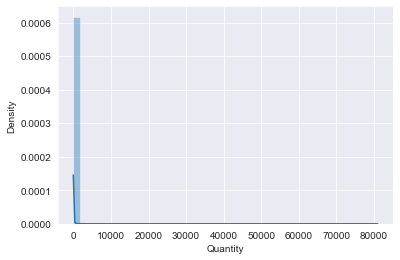

In [71]:
sns.distplot(df['Quantity'])

<AxesSubplot:xlabel='UnitPrice', ylabel='Density'>

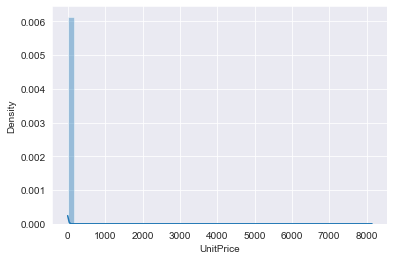

In [72]:
sns.distplot(df['UnitPrice'])

Dealing with outliers

In [73]:
def set_boundaries(df, variable):
    q1 = 0.05
    q2 = 0.95
    lower_boundary = df[variable].quantile(q1)
    upper_boundary = df[variable].quantile(q2)

    return lower_boundary, upper_boundary

def remove_outliers(df, variable):
    lower_boundary, upper_boundary =  set_boundaries(df,variable)
    df[variable] = np.where(df[variable] > upper_boundary, upper_boundary, np.where(df[variable] < lower_boundary, lower_boundary, df[variable]))

In [74]:
remove_outliers(df,'UnitPrice')
remove_outliers(df,'Quantity')

<AxesSubplot:xlabel='Quantity', ylabel='Density'>

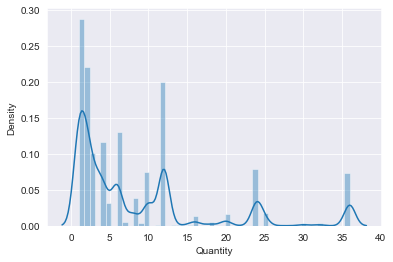

In [75]:
sns.distplot(df['Quantity'])

<AxesSubplot:xlabel='UnitPrice', ylabel='Density'>

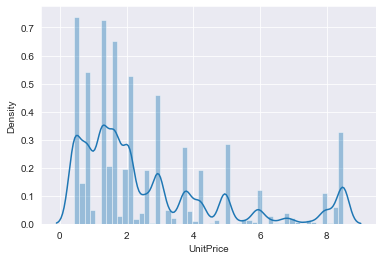

In [76]:
sns.distplot(df['UnitPrice'])

In [77]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,354321.000000,354321.000000,354321.000000
mean,8.348212,2.651029,15552.486392
std,9.245021,2.248187,1594.527150
min,1.000000,0.420000,12346.000000
25%,2.000000,1.250000,14194.000000
50%,4.000000,1.950000,15522.000000
75%,12.000000,3.750000,16931.000000
max,36.000000,8.500000,18287.000000


We will now create an RFM Dataset along with T(Time since customer's first purchase) and Monetary Value

In [78]:
# First we create a total price column
df['Total Price'] = df['UnitPrice'] * df['Quantity']

In [79]:
# We will create our RFM Dataset with the lifetimes package

rfm_dataset = lifetimes.utils.summary_data_from_transaction_data(df,'CustomerID','InvoiceDate','Total Price',observation_period_end='2011-12-09')
rfm_dataset

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12747.0,10.0,367.0,369.0,375.725000
12748.0,112.0,373.0,373.0,257.314911
12749.0,3.0,210.0,213.0,999.106667
12820.0,3.0,323.0,326.0,256.573333
...,...,...,...,...
18280.0,0.0,0.0,277.0,0.000000
18281.0,0.0,0.0,180.0,0.000000
18282.0,1.0,119.0,126.0,69.340000


In [80]:
# We require customers who have shopped more than once

rfm_dataset = rfm_dataset[rfm_dataset['frequency'] > 1]
rfm_dataset

,frequency,recency,T,monetary_value
CustomerID,,,,
12747.0,10.0,367.0,369.0,375.725000
12748.0,112.0,373.0,373.0,257.314911
12749.0,3.0,210.0,213.0,999.106667
12820.0,3.0,323.0,326.0,256.573333
12823.0,4.0,222.0,296.0,252.450000
...,...,...,...,...
18263.0,2.0,227.0,252.0,467.580000
18272.0,5.0,244.0,246.0,485.688000
18273.0,2.0,255.0,257.0,71.400000


In [81]:
# We will now import BetaGeoFilter to implement the BG/NBD model to our data
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(rfm_dataset['frequency'], rfm_dataset['recency'], rfm_dataset['T'])

<lifetimes.BetaGeoFitter: fitted with 1738 subjects, a: 0.00, alpha: 112.07, b: 0.00, r: 2.38>

In [82]:
# Now we will predict expected number of purchases for 6 months
t = 180
rfm_dataset['expected_purc_6_months'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, rfm_dataset['frequency'], rfm_dataset['recency'], rfm_dataset['T'])
rfm_dataset.sort_values(by='expected_purc_6_months',ascending=False).head(5)

,frequency,recency,T,monetary_value,expected_purc_6_months
CustomerID,,,,,
12748.0,112.0,373.0,373.0,257.314911,42.444401
17841.0,111.0,372.0,373.0,349.079640,42.073324
15311.0,89.0,373.0,373.0,421.881573,33.909635
14606.0,88.0,372.0,373.0,125.302955,33.538559
12971.0,70.0,369.0,372.0,132.197571,26.914663


Now to predict the CLV we will use the Gamma-Gamma Model

In [83]:
# To use Gamma Gamma, we must first ensure there is LESS/WEAK correlation between Frequency and Monetary Value

rfm_dataset[['frequency','monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.082631
monetary_value,0.082631,1.000000


In [84]:
# Since there is less correlation we will proceed to build the Gamma Gamma Model
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(rfm_dataset["frequency"],
        rfm_dataset["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 1738 subjects, p: 3.80, q: 0.35, v: 3.73>

In [86]:
# We will now

rfm_dataset['6_months_clv']=ggf.customer_lifetime_value(bgf,
                                                 rfm_dataset["frequency"],
                                                 rfm_dataset["recency"],
                                                 rfm_dataset["T"],
                                                 rfm_dataset["monetary_value"],
                                                 time=6,
                                                 freq='D',
                                                 discount_rate=0.01)
rfm_dataset.sort_values('6_months_clv',ascending=False).head()

,frequency,recency,T,monetary_value,expected_purc_6_months,6_months_clv
CustomerID,,,,,,
14096.0,16.0,97.0,101.0,3012.454375,15.528400,45677.610915
18102.0,25.0,367.0,367.0,2112.843200,10.287978,21142.592872
13089.0,65.0,367.0,369.0,784.818308,25.211693,19164.137958
17511.0,27.0,371.0,373.0,1798.113704,10.902877,19058.975876
14088.0,11.0,312.0,322.0,3352.988182,5.549070,18258.492844


In [90]:
rfm_dataset['Segment'] = pd.qcut(rfm_dataset['6_months_clv'],4,labels = ['Hibernating','Need Attention',                                                      'LoyalCustomers', 'Champions'])
rfm_dataset

,frequency,recency,T,monetary_value,expected_purc_6_months,6_months_clv,Segment
CustomerID,,,,,,,
12747.0,10.0,367.0,369.0,375.725000,4.632775,1712.381633,Champions
12748.0,112.0,373.0,373.0,257.314911,42.444401,10566.853327,Champions
12749.0,3.0,210.0,213.0,999.106667,2.979965,3054.158128,Champions
12820.0,3.0,323.0,326.0,256.573333,2.211293,584.100407,Need Attention
12823.0,4.0,222.0,296.0,252.450000,2.814953,719.842220,Need Attention
...,...,...,...,...,...,...,...
18263.0,2.0,227.0,252.0,467.580000,2.166345,1074.547597,LoyalCustomers
18272.0,5.0,244.0,246.0,485.688000,3.710709,1805.476473,Champions
18273.0,2.0,255.0,257.0,71.400000,2.136996,165.434190,Hibernating


From our segmentation into 4 separate groups, we can identify groups of customers who require more attention, specific products and create marketing plan to address each group in a particular way.